In [6]:
import numpy as np
import pandas as pd
import requests
import json
import sys, os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [7]:
from src.Demand_class import Demand

In [8]:
ny = Demand('NY')

In [9]:
ny.load_data()

In [10]:
ny.dataframe.head()

,Time,Megawatthours
0,2015-07-01 02:00:00,16027.0
1,2015-07-01 03:00:00,15541.0
2,2015-07-01 04:00:00,15283.0
3,2015-07-01 05:00:00,15304.0
4,2015-07-01 06:00:00,15874.0


In [11]:
ny.dataframe.describe()

,Megawatthours
count,50868.000000
mean,17900.384842
std,3379.239434
min,11371.000000
25%,15481.000000
50%,17574.000000
75%,19588.000000
max,32076.000000


In [12]:
ny.dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50868 entries, 0 to 50867
Data columns (total 2 columns):
Time             50868 non-null datetime64[ns]
Megawatthours    50868 non-null float64
dtypes: datetime64[ns](1), float64(1)
memory usage: 794.9 KB


In [13]:
ny.create_time_features()

In [14]:
df = ny.time_features_df

In [15]:
df.head()

,Time,Megawatthours,Year,Month,Hour,Day_of_week,Day_of_month,Day_of_year
0,2015-07-01 02:00:00,16027,2015,7,2,2,1,182
1,2015-07-01 03:00:00,15541,2015,7,3,2,1,182
2,2015-07-01 04:00:00,15283,2015,7,4,2,1,182
3,2015-07-01 05:00:00,15304,2015,7,5,2,1,182
4,2015-07-01 06:00:00,15874,2015,7,6,2,1,182


In [16]:
df.describe()

,Megawatthours,Year,Month,Hour,Day_of_week,Day_of_month,Day_of_year
count,50868.000000,50868.000000,50868.000000,50868.000000,50868.000000,50868.000000,50868.000000
mean,17900.384780,2017.893253,6.566053,11.498938,3.001573,15.682944,184.489109
std,3379.239434,1.719471,3.497084,6.922084,1.999803,8.797055,106.947251
min,11371.000000,2015.000000,1.000000,0.000000,0.000000,1.000000,1.000000
25%,15481.000000,2016.000000,3.000000,5.000000,1.000000,8.000000,89.000000
50%,17574.000000,2018.000000,7.000000,11.000000,3.000000,16.000000,189.000000
75%,19588.000000,2019.000000,10.000000,17.000000,5.000000,23.000000,278.000000
max,32076.000000,2021.000000,12.000000,23.000000,6.000000,31.000000,366.000000


In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
lag_df = ny.create_lag_variables(ny.dataframe, 24, 24)

In [19]:
lag_df.head()

,Time,Megawatthours,0,1,2,3,4,5,6,7,...,14,15,16,17,18,19,20,21,22,23
48,2015-07-03 02:00:00,15179.0,16027.0,15541.0,15283.0,15304.0,15874.0,17161.0,18690.0,19956.0,...,23778.0,23804.0,23664.0,22984.0,22262.0,21746.0,21525.0,20149.0,18493.0,17090.0
49,2015-07-03 03:00:00,14519.0,15541.0,15283.0,15304.0,15874.0,17161.0,18690.0,19956.0,20971.0,...,23804.0,23664.0,22984.0,22262.0,21746.0,21525.0,20149.0,18493.0,17090.0,16052.0
50,2015-07-03 04:00:00,14107.0,15283.0,15304.0,15874.0,17161.0,18690.0,19956.0,20971.0,21849.0,...,23664.0,22984.0,22262.0,21746.0,21525.0,20149.0,18493.0,17090.0,16052.0,15356.0
51,2015-07-03 05:00:00,13947.0,15304.0,15874.0,17161.0,18690.0,19956.0,20971.0,21849.0,22471.0,...,22984.0,22262.0,21746.0,21525.0,20149.0,18493.0,17090.0,16052.0,15356.0,14936.0
52,2015-07-03 06:00:00,13996.0,15874.0,17161.0,18690.0,19956.0,20971.0,21849.0,22471.0,22809.0,...,22262.0,21746.0,21525.0,20149.0,18493.0,17090.0,16052.0,15356.0,14936.0,14884.0


In [20]:
lag_df.describe()

,Megawatthours,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
count,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,...,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000,50820.000000
mean,17898.701341,17904.116925,17904.084379,17904.059821,17904.043529,17904.031958,17904.014701,17903.976882,17903.915331,17903.831407,...,17902.791974,17902.565449,17902.338865,17902.119011,17901.917181,17901.734831,17901.566335,17901.402974,17901.266787,17901.164072
std,3379.231503,3378.475919,3378.501969,3378.523682,3378.538318,3378.548229,3378.560838,3378.579913,3378.594086,3378.596083,...,3378.542448,3378.534448,3378.524787,3378.513381,3378.516160,3378.530912,3378.552715,3378.578220,3378.627109,3378.688466
min,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,...,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000,11371.000000
25%,15480.000000,15487.750000,15487.000000,15487.000000,15487.000000,15487.000000,15486.750000,15486.000000,15486.000000,15486.000000,...,15485.000000,15485.000000,15484.750000,15484.000000,15484.000000,15483.750000,15483.000000,15483.000000,15483.000000,15483.000000
50%,17573.000000,17579.000000,17579.000000,17579.000000,17579.000000,17579.000000,17579.000000,17579.000000,17579.000000,17579.000000,...,17578.000000,17577.500000,17577.000000,17577.000000,17577.000000,17576.500000,17576.000000,17576.000000,17576.000000,17576.000000
75%,19584.000000,19590.000000,19590.000000,19590.000000,19590.000000,19590.000000,19590.000000,19590.000000,19590.000000,19590.000000,...,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19588.000000,19587.250000,19587.250000
max,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,...,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000,32076.000000


In [21]:
sclr = MinMaxScaler()

In [22]:
X_train, X_test, y_train, y_test = ny.scale_split(lag_df, '2020-03-01 00:00:00', sclr)

In [23]:
len(X_train)

40871

In [24]:
len(X_test)

9949

In [25]:
X_train, X_test, y_train, y_test = ny.reshape_for_rnn(X_train, X_test, y_train, y_test)

In [26]:
X_train.shape

(40871, 24, 1)

In [27]:
import matplotlib.pyplot as plt
import tensorflow
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from keras.layers import Dense, Dropout, SimpleRNN
from keras.models import Sequential

In [28]:
model = Sequential()

In [29]:
def create_layers_SimpleRNN(model, input_shape, units=200, activation='tanh', dropout=0.15):
    """Creates layers of the RNN model passed in. 

    Args:
        model (RNN obj): instance of a neural network model.
        input_shape (tup): shape of the input layer
        units (int, optional): Number of units in each layer; Defaults to 200. 
        activation (str, optional): Activation function.; Defaults to 'tanh'.
        dropout (float, optional): Dropout ratio; Defaults to 0.15.
    """
    model.add(SimpleRNN(units, activation=activation, return_sequences=True, 
                                input_shape=input_shape))
    model.add(Dropout(dropout))

    model.add(SimpleRNN(units, activation=activation, return_sequences=True))
    model.add(Dropout(dropout))

    model.add(SimpleRNN(units, activation=activation, return_sequences=False))
    model.add(Dropout(dropout))

    model.add(Dense(1))

In [30]:
create_layers_SimpleRNN(model, (X_train.shape[1], 1))

In [31]:
model

In [32]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 24, 200)           40400     
_________________________________________________________________
dropout (Dropout)            (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 24, 200)           80200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 200)           0         
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 200)               80200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                

In [33]:
def compile_and_predict(model, X_train, y_train, X_test, optimizer='adam', 
                            loss='MSE', epochs=10, batch_size=1000):
    """Compiles the RNN model passed to it using X_train and y_Train; predicts
    target variable from X_test.

    Args:
        model (RNN obj): Built RNN to be compiled and used to predict
        target variables
        X_train (arr): Training feature matrix
        y_train (arr): Training target matrix
        X_test (arr): Test feature matrix
        optimizer (str, optional): type of optimization used to compile 
        the RNN model. Defaults to 'adam'.
        loss (str, optional): Loss metric to be used to compile the 
        RNN model. Defaults to 'MSE'.
        epochs (int, optional): Number of epochs over which to train 
        RNN model. Defaults to 10.
        batch_size (int, optional): Batch size to be used in each step 
        during RNN training. Defaults to 1000.

    Returns:
        arr: Array of target variable predictions based on X_test
        matrix.
    """
    model.compile(optimizer=optimizer, loss=loss)

    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    
    predictions = model.predict(X_test)
    return predictions

In [47]:
preds = compile_and_predict(model, X_train, y_train, X_test, epochs=20)

Epoch 1/20
41/41 [==============================] - 7s 162ms/step - loss: 0.1841
Epoch 2/20
41/41 [==============================] - 7s 162ms/step - loss: 0.0345
Epoch 3/20
41/41 [==============================] - 7s 163ms/step - loss: 0.0173
Epoch 4/20
41/41 [==============================] - 7s 163ms/step - loss: 0.0130
Epoch 5/20
41/41 [==============================] - 7s 160ms/step - loss: 0.0112
Epoch 6/20
41/41 [==============================] - 7s 163ms/step - loss: 0.0101
Epoch 7/20
41/41 [==============================] - 7s 162ms/step - loss: 0.0093
Epoch 8/20
41/41 [==============================] - 7s 162ms/step - loss: 0.0088
Epoch 9/20
41/41 [==============================] - 7s 162ms/step - loss: 0.0082
Epoch 10/20
41/41 [==============================] - 7s 166ms/step - loss: 0.0078
Epoch 11/20
41/41 [==============================] - 7s 162ms/step - loss: 0.0076
Epoch 12/20
41/41 [==============================] - 7s 169ms/step - loss: 0.0074
Epoch 13/20
41/41 [======

In [48]:
preds

array([[0.2484882 ],
       [0.20356852],
       [0.18121925],
       ...,
       [0.10206826],
       [0.09645845],
       [0.09826798]], dtype=float32)

In [49]:
def unscale_y(y_array, scaler, n_lag_variables):
    """Reshapes target matrix so that it can be inverse
    scaled to extract predictions in original scale.

    Args:
        y_array (arr): target matrix; either predictions 
        or y_test
        scaler (scaler obj): instance of scaler, e.g. MinMaxScaler()
        n_lag_variables (int): number of lag variables used in the 
        feature matrix. Will add this many columns of zeros so that the
        y matrix matches the shape of the scaler

    Returns:
        [arr]: unscaled y_matrix 
    """
    zeros = np.zeros((len(y_array), n_lag_variables))
    y_with_zeros = np.concatenate([y_array, zeros], axis=1)
    unscaled_y = scaler.inverse_transform(y_with_zeros)[:, 0]
    return unscaled_y

In [50]:
unscaled_preds = unscale_y(preds, sclr, 24)

In [51]:
unscaled_preds

array([16861.64366348, 15952.24465019, 15499.78371552, ...,
       13897.37193002, 13783.80131944, 13820.43525348])

In [52]:
def mean_abs_percent_error(y_test, y_pred):
    """Calculates mean absolute percent error between y_test
    matrix and predictions from a supervised learning model.

    Args:
        y_test (arr): matrix of actual target values
        y_pred (arr): matrix of predicted target values

    Returns:
        float: error metric
    """
    y_test, y_pred = np.array(y_test), np.array(y_pred)
    return np.mean(np.abs((y_test - y_pred)/y_test)) * 100

In [53]:
y_test_unscaled = unscale_y(y_test, sclr, 24)

In [54]:
y_test_unscaled

array([16967., 16314., 15851., ..., 15171., 15402., 15585.])

In [55]:
mean_abs_percent_error(y_test_unscaled, unscaled_preds)

5.581162610772903

In [56]:
def plot_predictions_vs_true(ax, y_test, predictions, date_index):
    """Plots both y_true and y_predicted values on the same axes.

    Args:
        ax (axes): Axes on which to plot the predictions.
        y_test (arr): Matrix of actual target variables.
        predictions (arr): Matrix of predicted target variables.
        date_index (arr): Range of y_test indices; plotted along
        the x-axis
    """
    ax.plot(date_index, y_test, label='Actual')
    ax.plot(preds_index, predictions, alpha=0.5, label='Predicted')
    ax.legend(fontsize=12)
    ax.set_xlabel('Date', size=16)
    ax.set_ylabel('Megawatthours', size=16)

In [57]:
preds_index = lag_df['Time'].loc[lag_df['Time'] >= '2020-03-01 00:00:00']
preds_index = preds_index.values

/usr/local/lib/python3.5/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


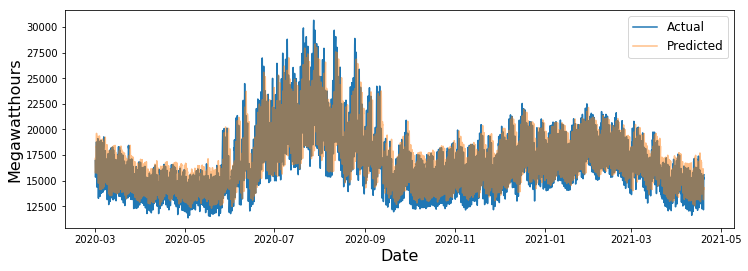

In [46]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_predictions_vs_true(ax, y_test_unscaled, unscaled_preds, preds_index)
plt.show()

## Try on another region

In [ ]:
tex = Demand('TEX')

In [ ]:
tex.load_data()

In [ ]:
tex.dataframe.head()

In [ ]:
tex_lag = tex.create_lag_variables(tex.dataframe, 24, 24)

In [ ]:
tex_lag.head()

In [ ]:
tex_X_train, tex_X_test, tex_y_train, tex_y_test = tex.scale_split(tex_lag, '2020-03-01 00:00:00', sclr)

In [ ]:
tex_X_train

In [ ]:
tex_X_train, tex_X_test, tex_y_train, tex_y_test = tex.reshape_for_rnn(tex_X_train, tex_X_test, tex_y_train, tex_y_test)

In [ ]:
tex_X_train.shape

In [ ]:
tex_model = Sequential()

In [ ]:
create_layers_SimpleRNN(tex_model, (tex_X_train.shape[1], 1))

In [ ]:
tex_preds = compile_and_predict(tex_model, tex_X_train, tex_y_train, tex_X_test)

In [ ]:
unscaled_tex_preds = unscale_y(tex_preds, sclr, 24)

In [ ]:
unscaled_tex_preds

In [ ]:
unscaled_tex_y_test = unscale_y(tex_y_test, sclr, 24)

In [ ]:
mean_abs_percent_error(unscaled_tex_y_test, unscaled_tex_preds)

In [ ]:
fig, ax = plt.subplots(figsize = (12, 4))
plot_predictions_vs_true(ax, unscaled_tex_y_test, unscaled_tex_preds, preds_index)
plt.show()